###### The cell below loads the visual style of the notebook when run.

In [0]:
from IPython.core.display import HTML
css_file = '../../styles/styles.css'
HTML(open(css_file, "r").read())

# Calibrating CCD data

<section class="objectives panel panel-warning">
<div class="panel-heading">
<h2><span class="fa fa-certificate"></span>Learning Objectives</h2>
</div>
</section>

> * How to use the ```astropy``` library to read in FITS images
> * How to display FITS images
> * How to access FITS headers
> * How to add, subtract divide and combine images
> * Bias subtract, dark subtract and flat-field images

In the [lectures](http://slittlefair.staff.shef.ac.uk/teaching/phy241/lectures/L06/index.html) we covered the basics of how CCDs work. Once we have a CCD image we'd like to use it for some scientific purpose. For example we might like to perform absolute photometry on the stars in the images.

Usually, before doing that, we must perform some additional processing on the image. We'll look at why later in this practical. Before we do that, let's examine the file format that CCD images come in, and how to deal with it in Python.

<div class="alert alert-info">
<h3><span class="fa fa-exclamation"></span>  A Note on Kernels</h3>
<p>We will be using some Python libraries, or modules, which are not available on all the Python kernels in CoCalc. <b>Make sure you select the Python 3 (system-wide) kernel from the Kernel menu in the notebook before proceeding</b></p>
</div>

---

## FITS images

The FITS (Flexible Image Transport System) file format is the most common data format for astronomical images and data. We need to know a little bit about it to deal with it.

### HDUs
A FITS file contains one or more Header/Data Units (HDUs). Each HDU contains a header, which contains some information about the file, and an optional data unit. For example, a FITS file containing a CCD image would have one HDU - the header would describe the data, and the data would be the CCD image itself.

## Reading FITS images

The [astropy](http://www.astropy.org) library is a huge Python library with many, many useful goodies for astronomers to use. Amongst those is a library purely for reading and writing FITS files. We import it like so:



In [1]:
# The "fits" library contains functions for reading and writing FITS files.
from astropy.io import fits

# let's also import some standard modules
import numpy as np
# display plots in notebook
%matplotlib inline
import matplotlib.pyplot as plt

We'll also need a FITS file to play with. We'll use the pleiades image from Session2

For most FITS files, particularly for simple images, we can get the header and the data from the file like so:

In [2]:
image_file = '../../data/Session2/pleiades.fits'
image_data = fits.getdata(image_file)
image_hdr  = fits.getheader(image_file)

For more complicated FITS files, with many HDUs you might need to do something more advanced - for those cases look at the [documentation](http://astropy.readthedocs.org/en/stable/) for help!

---

## Image Data

The image_data is just a 2D numpy array, so we can use all the wonderful numpy [goodness](http://slittlefair.staff.shef.ac.uk/teaching/phy241/practicals/P03/index.html) with them:

In [3]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(875, 875)


We can use the same code we saw in the [plotting practical](http://nbviewer.ipython.org/github/StuartLittlefair/PHY241/blob/master/release/Session2/01_plotting.ipynb) to display the image data. If you find the representation and scaling of image data a bit confusing you may want to look at the companion notebook (`05a-imagescaling.ipynb`).

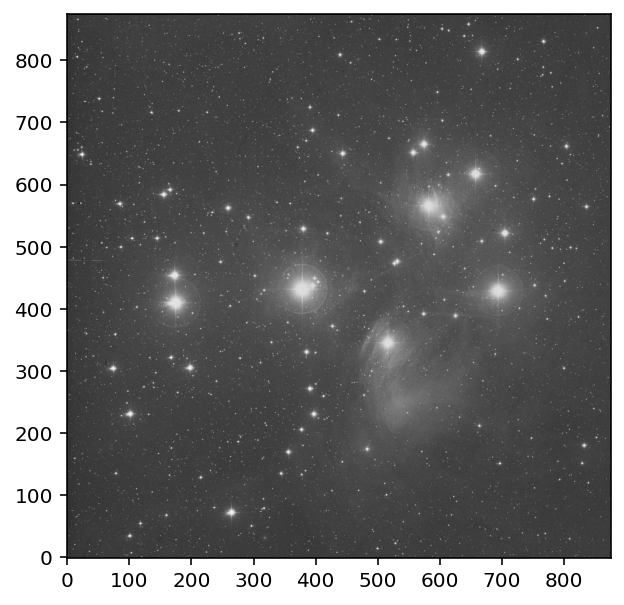

In [4]:
fig, axis = plt.subplots(figsize=(5, 5))
implot = axis.imshow(image_data, cmap='gray', origin='lower')
axis.grid(False)
plt.show()

---

## Header Data

Let's take a look at the image header we read in earlier

In [5]:
image_hdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  875 / length of data axis 1                          
NAXIS2  =                  875 / length of data axis 2                          
BZERO   =                   0. / PhysValue = BZERO + BSCALE * ArrayValue        
BSCALE  =            0.0001526 / PhysValue = BZERO + BSCALE * ArrayValue        
COMMENT Standard WCS reduction:                                                 
CRVAL1  =     56.7489909930614 / WCS Ref value (RA in decimal degrees)          
CRVAL2  =     24.1176620538817 / WCS Ref value (DEC in decimal degrees)         
CRPIX1  =                437.5 / WCS Coordinate reference pixel                 
CRPIX2  =                437.5 / WCS Coordinate reference pixel                 
CD1_1   = -0.001885281060452

You can see that the image header is typically used to store information about the image. The header can include information about the object, the exposure time, the filter used etc. All the items in the header follow a ```name = value``` pattern. The header can be accessed like a Python [dictionary](http://interactivepython.org/courselib/static/thinkcspy/Dictionaries/intro-Dictionaries.html). For simplicity, I've avoided discussing dictionaries in the course so far. However, they are **extremely** useful. Dictionaries are a bit like lists, but instead of accessing elements by index (e.g ```list[0]```) we can access them by name. 

Thus, if we want the MJD-OBS item from the fits header we can access it like so:

In [6]:
print( image_hdr['MJD-OBS'] )

33979.2770833333


## Writing FITS images

So, that's how you read image data from a FITS file. How do we write our own data?

The key to writing our own FITS files is to know that all FITS files must contain a Primary HDU - i.e the first HDU. We write a FITS file by creating a Primary HDU object, and using it's ```writeto``` method:

In [9]:
hdu = fits.PrimaryHDU(data=image_data)
hdu.writeto('my_new_fits_file.fits', overwrite=True)

The ```overwrite=True``` argument means that the file will be over-written if it already exists. Otherwise it will raise an exception. If we want to provide a header for the FITS file we can, but note that this is optional: 

In [10]:
hdu = fits.PrimaryHDU(data=image_data, header=image_hdr)
hdu.writeto('my_new_fits_file.fits', overwrite=True)

---

# An introduction to CCD Data processing

Before we can use CCD data for quantitative measurements, we have to perform some corrections to the data. This process is known as "reducing" the data.

```ccdproc``` is a Python package which has been written to make reducing CCD data for astronomy simple. There is some documentation available [here](http://ccdproc.readthedocs.io/en/latest/). If you have selected the Anaconda (Python 3) kernel, then ccdproc will be available and installed.  

If you are running on the managed desktop or your own laptop, ```ccdproc``` and it's dependencies will not be installed. You need to start a terminal (linux, OS X), or an Anaconda command prompt (windows) and install ```ccdproc```. It is installed by typing ```pip install ccdproc```.

Whilst ```ccdproc``` is a great package, using it directly can involve a lot of code just to keep track of which files are which, and to find the appropriate type of image to use for each step. To make life simpler, I have written some Python code you can re-use in your own project. The code is located in the file called ```reduction_tools.py``` which should be located in the same folder as this notebook - you can take a look at it if you like, but it's pretty advanced Python so don't worry if it makes little sense. 

The code from this file can be imported like any other Python library, **provided it is in the same directory as the notebook you are running**. The code defines two Python objects, one for reducing CCD frames (called `Reducer`), the other for combining several frames (called `Combiner`).

Below we import the necessary modules, including the code I wrote:

In [11]:
import ccdproc # the ccdproc library
from reduction_tools import Combiner, Reduction # my custom tools for combining and `reducing` CCD data.

# Data Location

Before we get started, first we need to set two variables - the directory where the data is located, and the directory where we want to store the calibrated data. We are going to store the data you took for the observing project in a folder at the **top level** of the PHY241 project in the CoCalc. The full path to this folder will be `/home/user/PHY241/observing_project` and we are going to create two sub-folders within that main folder. One is called `raw_data` and will contain the data we took from the telescope. Another folder `calib_data` will contain the data after we have processed it in this notebook.

The code cell below will create those directories for us, if they don't exist, using the `os` Python module, which is useful for interacting with the computer operating system (OS).

In [12]:
root_folder = '/home/user/PHY241/observing_project/'
data_folder = root_folder + 'raw_data'
destination_folder = root_folder + 'calib_data'

import os  # the os library contains functions for working with the file system

# make root folder ONLY if it does not exist
if not os.path.exists(root_folder):
    os.mkdir(root_folder)

# make destination directory ONLY if it does not exist
if not os.path.exists(destination_folder):
    os.mkdir(destination_folder)

# make data directory ONLY if it does not exist
if not os.path.exists(data_folder):
    os.mkdir(data_folder)

# Uploading your observed data

We need to upload the data you observed for your project to cocalc, into the directory '/home/user/PHY241/observing_project/raw_data'. Using the ```Files``` tab in the top-left of ```CoCalc```, navigate to that directory and use the ```upload``` button (below), to upload the raw data you took, including image files, bias frames, dark frames and flat fields.

<img style="margin: 20px" src="../../images/upload_button.png"/>

### Load the dataset into Python

In all the examples below, try and understand what is happening, but don't worry too much about understanding all the details of the code - the idea is to present you with a template you can use to reduce data in future...

```ccdproc``` defines a type of object known as an ```ImageFileCollection``` which, once created has lots of nice ways to summarise the data and the contents of the FITS headers. To create one we require two arguments, the directory containing the data and a list of FITS header items we are interested in:

In [13]:
images = ccdproc.ImageFileCollection(location=data_folder, keywords=['imagetyp', 'exposure', 'filter'])

With an ```ImageFileCollection``` created, we can get a look at what files are in the data dir as shown below. 

In [14]:
print(images.summary)

        file          imagetyp  exposure filter
------------------- ----------- -------- ------
         bias_1.fit  Bias Frame      0.0     --
         bias_2.fit  Bias Frame      0.0     --
         bias_3.fit  Bias Frame      0.0     --
     dark_300_1.fit  Dark Frame    300.0     --
     dark_300_2.fit  Dark Frame    300.0     --
     dark_300_3.fit  Dark Frame    300.0     --
      dark_30_1.fit  Dark Frame     30.0     --
      dark_30_2.fit  Dark Frame     30.0     --
      dark_30_3.fit  Dark Frame     30.0     --
      dark_30_4.fit  Dark Frame     30.0     --
                ...         ...      ...    ...
ngc7789_b_300_2.fit Light Frame    300.0      B
ngc7789_b_300_3.fit Light Frame    300.0      B
 ngc7789_b_30_1.fit Light Frame     30.0      B
 ngc7789_b_30_2.fit Light Frame     30.0      B
 ngc7789_b_30_3.fit Light Frame     30.0      B
ngc7789_v_300_1.fit Light Frame    300.0      V
ngc7789_v_300_2.fit Light Frame    300.0      V
ngc7789_v_300_3.fit Light Frame    300.0

<section class="panel panel-info">
<div class="panel-heading">
<h2><span class="fa fa-thumb-tack"></span>  What FITS header items are important?</h2>
</div>
</section>

> Notice the IMAGETYP entry in the table below. This is created from the IMAGETYP entry in the FITS header for each file. It labels each file as being a `Bias Frame`, `Dark Frame`, `Flat Field` or (for our science data) `Light frame`. These types of frames are discussed below, including a discussion of how they are taken, and what they are used for.

> The ```reduction_tools``` code we imported above has to know which frames are which type and it is therefore crucial that the IMAGETYP entry is defined in the FITS header. Data you take on the 16-inch telescope should have this defined. However, sometimes there is no indication in the FITS header what kind of image the file contains. If this is the case for your data, the first step you may need to take is to **edit** the FITS header of your data files, following the instructions in the notebook `05b-editing_headers.ipynb`.

---

# Calibrating CCD Images

OK, now we know how to read and write FITS files. Let's look at what calibrations we need to perform on CCD images - why we need to do them and how to do them in Python. The material in this section is **examinable**, so make sure you remember to revise this come exam time.

## Bias Frames

Let's recall how a CCD measures the number of electrons $N_e$ in each pixel. These electrons have a total charge $Q=eN_e$. We measure this charge by dumping it onto a capacitor with capacitance $C$ and measuring the voltage $V=Q/C$. We can re-write the number of electrons in terms of this tiny, analog voltage as

$$ N_e = CV/e .$$

In other words, the voltage is proportional to the number of electrons. Because we need to store the data in digital format, the analog voltage is converted to a digital number of *counts* $N_c$, by an analog-to-digital converter (ADC). Since the value in counts is proportional to the voltage $N_c \propto V$, it follows that the number of counts is proportional to the number of photo-electrons, i.e $N_e=GN_c$, where $G$ is the *gain*, measured in e-/ADU. The number of bits used by the ADC to store the count values limits the number of different count values that can be represented. For a 16-bit ADC, we can represent count values from 0 to 65,535.

Now, imagine a relatively short exposure, taken from a dark astronomical site. Suppose that the gain, $G=1$ e-/ADU and that in our short exposure we create, on average, two photo-electrons from the sky in each pixel. Because of [readout noise](http://slittlefair.staff.shef.ac.uk/teaching/phy241/lectures/L08/index.html#readout), we will NOT have 2 counts in each pixel. Instead, the pixel values will follow a Gaussian distribution, with a mean of 2 counts, and a standard deviation given by the readout noise, which may be of the order of 3 counts. It should be obvious that this implies that many pixels should contain *negative count values*. However, **our ADC cannot represent numbers less than 0!** This means our data has been corrupted by the digitisation process. If we didn't fix this, it would cause all sorts of problems: in this case it would lead us to over-estimate the sky level.

The solution is to apply a *bias voltage*. This is a constant offset voltage applied to the capacitor before analog-to-digital conversion. The result is that, even if the pixel contains no photo-electrons, there is a voltage on the capacitor and the ADC returns a value of a few hundred counts, nicely solving the issue of negative counts. However, it does mean that we must correct for the bias level when doing photometry! Each pixel in our image contains counts from stars, from the sky background and from the bias level. We must **subtract the bias level** before performing photometry. 

### Measuring the bias level

How do we know what the bias level is? The easiest way to do this is to take a series of images with zero exposure time. Because there is no exposure time, these images contain no photo-electrons, and no thermally excited electrons. These images, known as *bias frames*, allow us to measure the bias level, and subtract it from our science data. Several bias frames are needed because the value of any pixel in a given bias frame will differ from the bias level due to readout noise. Averaging several frames together reduces the impact of readout noise and gives a more accurate estimate of the bias level. The *master bias frame* produced from this averaging can be subtracted from all science images to remove the bias level from each pixel.

### Calculating the master bias frame

There are three bias frames in the ```data_folder```. The command below will simply perform some housekeeping on the headers of these files, and copy them to the ```destination_folder```. The ```input_image_collection``` argument sets the source of the images to be the ```ImageFileCollection``` we created above, whilst the ```destination``` argument sets where the files will be copied to. Also, take note that  the ```apply_to``` argument is used to select which type of files will be combined - in this case, only `Bias Frame` files will be copied. Finally, the ```copy_only``` argument means we only copy the files, and do not perform any further processsing:

In [15]:
# define the Reduction task
copy_file_task = Reduction(input_image_collection=images, 
                           destination=destination_folder, 
                           apply_to={'imagetyp': 'Bias Frame'},
                           copy_only=True)

# the line above simply creates the Reduction task object. To run it, call it's `action` function, like so
copy_file_task.action()

Now we can combine the copied files to make a master bias frame. First we must make a new ```ImageFileCollection``` to keep track of the files in the ```destination_folder```. Then we run the ```Combiner``` task.  Notice how the ```image_source``` argument is set to the ```ImageFileCollection``` we create? Also, note that the ```apply_to``` argument is again used to make sure we only combine BIAS files.

We can also set the name of the resulting file (in this case "master_bias") and set the combine method ('average' or 'median') and the destination directory. Run the code cell below to combine our three bias frames into a master bias.

In [16]:
reduced_images = ccdproc.ImageFileCollection(location=destination_folder, keywords=['imagetyp', 'exposure', 'filter', 'master'])

make_master_bias = Combiner(image_source=reduced_images,
                            file_name_base='master_bias',
                            combine_method='average',
                            apply_to={'imagetyp':'Bias Frame'},
                            destination=destination_folder)
make_master_bias.action()

If all that worked successfully, we will have created a master bias frame in our ```destination_folder```. Let's use the built-in ```os``` module to take a look!

In [17]:
os.listdir(destination_folder)

['master_bias.fit',
 'bias_3.fit',
 'dark_30_6.fit',
 'dark_30_1.fit',
 'dark_300_3.fit',
 'flat_v_3.fit',
 'master_dark_exposure_30.0.fit',
 'flat_b_3.fit',
 'bias_2.fit',
 'flat_b_2.fit',
 'master_dark_exposure_300.0.fit',
 'flat_v_2.fit',
 'dark_300_2.fit',
 'flat_b_1.fit',
 'master_flat_filter_V.fit',
 'flat_v_1.fit',
 'dark_300_1.fit',
 'bias_1.fit',
 'dark_30_4.fit',
 'dark_30_3.fit',
 'master_flat_filter_B.fit',
 'dark_30_2.fit',
 'dark_30_5.fit']

In [20]:
print(destination_folder, type(destination_folder))
print(os.path.join(destination_folder, 'bias_1.fit'))

/home/user/PHY241/observing_project/calib_data <class 'str'>
/home/user/PHY241/observing_project/calib_data/bias_1.fit


Now that we've made and saved our masterbias - let's take a look at it.

/home/user/PHY241/observing_project/calib_data/master_bias.fit
The masterbias has mean level of 947.9 counts


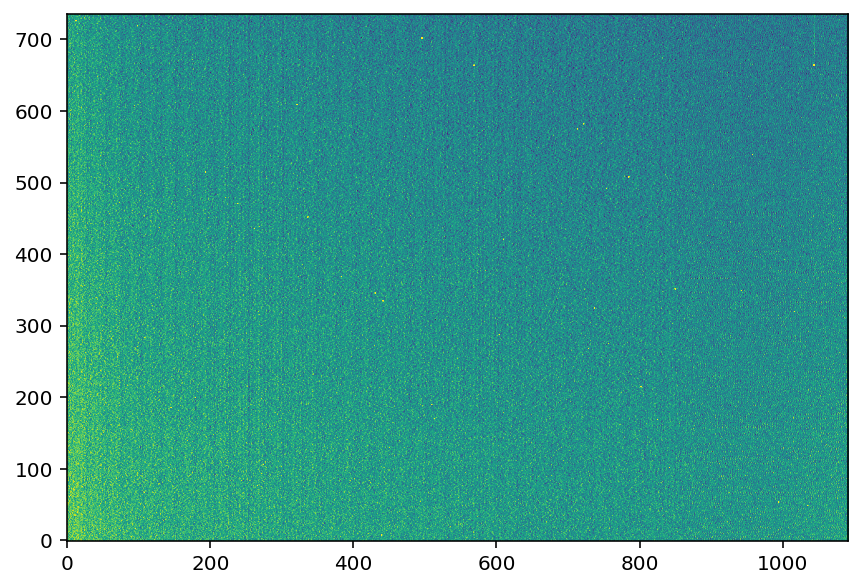

In [21]:
# use 'os' Python module to glue directories and filenames together easily
filepath = os.path.join(destination_folder, 'master_bias.fit')
print(filepath)

# open the file and store data in array called 'masterbias'
masterbias = fits.getdata(filepath)

# What's the mean level in the bias image?
print('The masterbias has mean level of {:.1f} counts'.format( masterbias.mean() ))

# display it
fig, axis = plt.subplots(figsize=(7, 7))

# custom scaling - see companion notebook
vmin,vmax = np.percentile(masterbias, [1,99])
implot = axis.imshow(masterbias, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axis.grid(False)
plt.show()

<section class="challenge panel panel-success"> 
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span>Read noise</h2>
</div>
</section>

> Calculate the mean and standard deviation of the master bias, and a single bias frame. Note how averaging the bias frames has reduced the standard deviation around the mean level.

> Now subtract the master bias array from the data array for a single bias. Has the std deviation gone down? Did subtracting a bias remove the readout noise? Do you know why not?

In [22]:
# CALCULATE VALUES FOR MEAN AND STD DEV OF MASTER BIAS HERE
# REMEMBER, THE DATA IS READ INTO NUMPY ARRAYS, SO ALL THE USUAL ARRAY METHODS WILL WORK
print(np.mean(masterbias))
print(np.std(masterbias))

# Here's how to make a variable containing the "path" to a single bias frame
singlebiaspath = os.path.join(destination_folder, 'bias_1.fit')
single_bias = fits.getdata(singlebiaspath)
# NOW USE the astropy fits library to read in the data from this file

# CALCULATE VALUES FOR MEAN AND STD DEV OF SINGLE BIAS HERE
print(np.mean(single_bias), np.std(single_bias))

947.9417
9.385643
947.94635 15.086458


---

## Dark Frames

[Recall](http://slittlefair.staff.shef.ac.uk/teaching/phy241/lectures/L08/index.html#semiconductors) that photo-electrons are produced in CCDs by photons exciting electrons from the valence band to the conduction band. However, this is not the only way to excite electrons into the conduction band. *Thermal excitation* is also capable of producing electrons in the conduction band. Thermal excitation of electrons is known as *dark current* and the electrons produced by it are indistinguishable from photo-electrons.

Dark current can be very substantial. At room temperature, the dark current of a standard CCD is typically 100,000 e-/pixel/s, which is sufficient to saturate most CCDs in only a few seconds! The solution is to cool the CCD. The typical operating temperatures of CCDs are in the range 150 to 263 K (i.e. -123 to -10$^{\circ}$C). At major observatories, most CCDs are cooled to the bottom end of this range, generally using liquid nitrogen. The resulting dark current can be as low as a few electrons per pixel per hour. The CCDs on the Hicks telescopes are air-cooled to a few degrees below zero, and have dark currents of around 40 e-/pixel/hour. 

Neither of these values are negligible, especially for long exposures. Thus, every pixel in our image contains contributions from stars, sky background, bias level and dark current. The dark current must be measured, and subtracted from our science images for the same reasons as the bias level. For this purpose *dark frames* are taken. These are long exposures, taken with the shutter closed. These frames will have no contribution from photo-electrons, but they will contain dark current and the bias level. **This means that dark frames must have the bias subtracted from them before use.** Once the bias level has been subtracted off, several dark frames can be combined to make a *master dark frame*, which can be subtracted from your images. 

It is best to combine the dark frames using the **median**, rather than the mean. Dark frames are often long exposures, which can be affected by cosmic rays. Cosmic rays hitting the CCD will excite also excite electrons. Taking the median of the master dark will help remove cosmic rays from the master dark frame.

Because the dark frame increases with time, it is easiest if the dark frames have the same exposure time as your science images. If they do not, it is possible to scale the dark frame by the ratio of exposure times, since dark current increases (roughly) linearly with time. Dark current is also a strong function of temperature - it is essential that dark frames are taken with the CCD at the same temperature as your science frame. 

### Calculating the master dark

In the raw data directory are three dark frames. Each one needs to be bias subtracted, and then combined with a median.

<section class="challenge panel panel-success"> 
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span>Subtract bias from darks</h2>
</div>
</section>

> Using the code cell below, subtract the bias from the darks. You should just be able to run the cell, but **read it carefully** and make sure
you can guess what each of the arguments do.

> Note how the ```bias_subtract```, ```dark_subtract``` and ```flat_correct``` control which reduction steps are carried out. Also note that the ```master_source``` sets which collection of images will be searched for suitable master bias frames. The other arguments should be familiar now.

In [0]:
dark_preprocessing = Reduction(bias_subtract=True,  # subtract bias from frames
                               dark_subtract=False,  # don't subtract darks
                               flat_correct=False,  # don't divide by flat field
                               master_source=reduced_images,  # look in `reduced_images` for master frames to use
                               input_image_collection=images,  # look in `images` for frames to work on
                               destination=destination_folder,  # write output files to `destination_dir`
                               apply_to={'imagetyp': 'dark frame'})  # only operate on frames with `imagetyp` equal to `dark frame`
dark_preprocessing.action()

<section class="challenge panel panel-success"> 
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span>Make a master dark</h2>
</div>
</section>

> Using the code cell below, create and save a master dark frame. You shouldn't need to change any of the code. Notice that I've changed the combine method to `median` as discussed above.

> Note the ```group_by``` argument in the ```Combiner```. The ```Combiner``` will make a master frame for each value of the FITS keyword listed in ```group_by```. By default this keyword is named exposure for darks, so if you have darks with exposure times of 10 sec, 15 sec and 120 sec you will get three master darks, one for each exposure time.

In [0]:
make_master_dark = Combiner(file_name_base='master_dark',
                            combine_method='median',
                            image_source=reduced_images,
                            apply_to={'imagetyp':'dark frame'},
                            group_by='exposure',
                            destination=destination_folder)
make_master_dark.action()

Listing the contents of the ```destination_folder``` we should have several bias subtracted darks (dark_30_1.fit, etc) and master dark for each exposure time:

In [0]:
os.listdir(destination_folder)

Having made a masterdark image - let's plot it:

In [0]:
filepath = os.path.join(destination_folder, "master_dark_exposure_300.0.fit")

masterdark_im = fits.getdata(filepath)

# What's the mean level in the dark image?
print('The masterdark has mean level of {:.1f} counts'.format( masterdark_im.mean() ))

# display it
fig, axis = plt.subplots(figsize=(9, 9))
# custom scaling - see companion notebook
vmin,vmax = np.percentile(masterdark_im, [1,99])
implot = axis.imshow(masterdark_im,cmap='gray',origin='lower',vmin=vmin,vmax=vmax)
axis.grid(False)
plt.show()

The average level should be a positive number of less than 50 counts, depending on the CCD temperature when your data was taken. What is the exposure time? We can read in the header of the dark frames to find out:

In [0]:
# use os.path.join to glue together directory and filename
dark_fits_filename = os.path.join(destination_folder, 'dark_300_1.fit') # you may need to change the file name here to match yours...
img_hdr = fits.getheader(dark_fits_filename) # read in FITS header using astropy's fits library
print(img_hdr['EXPOSURE'])

So there's a mean dark current of <50 counts in a 300 second exposure. Note that not every pixel has the same value. Some of this is read noise, but it is also true that different pixels in a CCD show different levels of dark current. Some pixels show very high levels of dark current - these so called hot pixels can have a very serious effect on your photometry if your target star happens to lie on top of one!

---

## Flat Fields

Suppose we use our telescope and CCD to take an image of a perfectly uniform light source. Would every pixel have the same number of counts in it? No - as we have seen each pixel will have a varying contribution from dark current and readout noise. What if we ignored these effects? The answer is still no. Various effects combine to mean that the count level can vary significantly across the image.

Below is an image of the twilight sky taken with the ROSA telescope on the roof of the Hicks building. On the small image scale of a telescope, the twilight sky is an excellent approximation to a uniformly illuminated light source. However, the image below is far from uniform.

<img src="../../images/rosa_flat.png" width=500></img>

There are three main reasons for the structure in this image:

1. **Vignetting**

    Consider the [design](http://slittlefair.staff.shef.ac.uk/teaching/phy241/lectures/L05/index.html#newtonian) of the Newtonian telescope. If the secondary mirror is exactly the right size to fit the beam produced by an on-axis source, some fraction of the beam produced by an off-axis source will miss the secondary mirror. This light will be lost, and off-axis sources will appear dimmer than on-axis sources. This is vignetting, and its effect is clearly visible in the figure above. 

2. **Pixel-to-Pixel variations**

    Each pixel in a CCD is not exactly the same size; manufacturing tolerances mean that some pixels are larger than others. If each CCD pixel is exposed to a constant flux, the variation in pixel area means that some pixels will capture more photons than others. This effect can also be seen in the figure above if you look closely, and is often called flat field grain. 

3. **Dust grains on optical surfaces**

    Dust grains on the window of the CCD, or on the filters will block out a small fraction of the light falling on the CCD. These grains appear as dark donuts, with the size of the donut depending on how far from the focal plane the dust grain is. Two such donuts are visible inthe figure above.
    
### Flat Field Frames

It is essential to correct our images for these effects. If we did not, the number of counts from an object would vary depending upon its location in the image, ruining our photometry. Fortunately, we can correct these effects using *flat field frames*. These are images taken of the twilight sky, which is assumed to be uniform (this is a good assumption for most instruments). Any variation in the flat field is therefore due to the effects above. Because vignetting and the contribution from dust grains can depend on the filter, flat fields must be taken in the same filters as your science data. 

For small telescopes, it can be more convenient to use a specially constructed flat-field panel. These panels are carefully designed to provide a uniform light source. The advantage of a flat field panel over the twilight sky is that flat fields can be taken at any time, whereas twilight flats can only be taken in a narrow window after sunset. The 16" Hicks telescope has a flat field panel for taking flat fields.

How should the flat field be used? First of all, we must realise that the flat field image must be **bias subtracted**. Dark frame subtraction is not normally necessary, since exposure times are short and the dark current will be very small. The count level of pixel $(i,j)$ in the bias-subtracted flat field image can be written as

$$F_{ij} = \alpha_{ij} F,$$

where $F$ is the uniform flux of the twilight sky, or flat field panel. The quantity $\alpha_{ij}$ represents the fraction of light lost to vignetting, pixel-to-pixel variations and dust grains. If we normalise our image, i.e. divide the flat field by the mean flux, $F$, we get an image whose brightness $f$ is given by $f_{ij}=\alpha_{ij}$. Our science image is given by the product of the flux falling on each pixel $G_{ij}$, and the flat field effects, giving an image in which the brightness of pixel $(i,j)$ is given by 

$$ G'_{ij} = G_{ij}\alpha_{ij}.$$

**Dividing** our science image, $G'_{ij}$, by the normalised flat field image, $\alpha_{ij}$, gives the actual flux falling on each pixel $G_{ij}$, as desired.

### Calculating the master flat frame

Usually we take several flat fields in each filter. These must all be bias subtracted and averaged together. The average frame produced must be normalised: divided by its mean.

<section class="challenge panel panel-success"> 
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span>Bias subtract the flat fields</h2>
</div>
</section>


> In the data directory you should have a few twilight flat fields taken through the each filter.

> You should be able to run the code cell below to bias subtract the flat fields:

In [23]:
flat_reduction = Reduction(bias_subtract=True,
                           dark_subtract=False,
                           flat_correct=False,
                           master_source=reduced_images,
                           input_image_collection=images,
                           destination=destination_folder,
                           apply_to={'imagetyp':'flat field'})
flat_reduction.action()

<section class="challenge panel panel-success"> 
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span>Make a master flat</h2>
</div>
</section>

> This should be pretty similar to when we procude a master dark. Again, note the presence of ```group_by```. This allows us to produce one flat field per filter observed.

In [24]:
make_master_flat = Combiner(file_name_base='master_flat',
                            group_by='filter',
                            image_source=reduced_images,
                            destination=destination_folder,
                            apply_to={'imagetyp':'flat field'})
make_master_flat.action()

As we have done before - let's plot a flat field image and look at the mean level.

The masterflat has mean level of 25475.7 counts


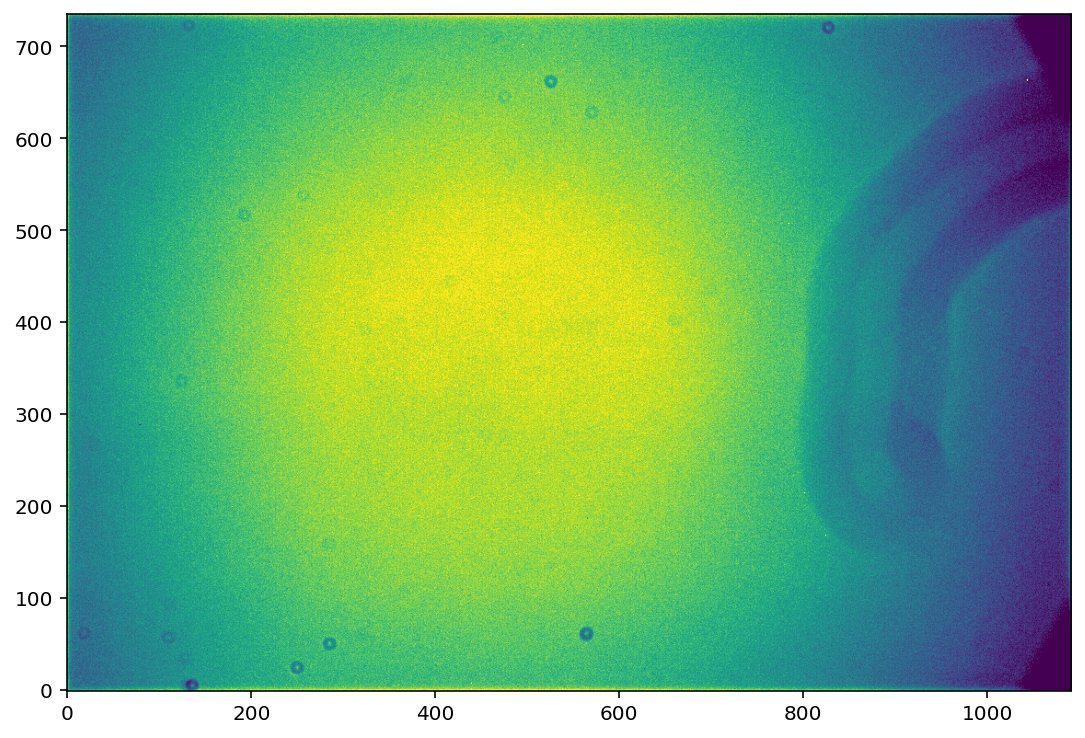

In [25]:
# change the filename if necessary to match the name of your V band flat
filepath = os.path.join(destination_folder, "master_flat_filter_V.fit")

masterflat_im = fits.getdata(filepath)

# What's the mean level in the dark image?
print('The masterflat has mean level of {:.1f} counts'.format( masterflat_im.mean() ))

# display it
fig, axis = plt.subplots(figsize=(9, 9))
# custom scaling - see companion notebook
vmin,vmax = np.percentile(masterflat_im, [1,99])
implot = axis.imshow(masterflat_im, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axis.grid(False)
plt.show()

Notice how the flat field has a mean of ~25,000 counts. If we were doing this by hand we would normalise the flat field before using it. However, in this case, my ```Reduction``` object will take care of the normalisation when we use the flat field to correct our data. The structure due to vignetting, flat field grain and "donuts" from dust on the optical surfaces are clearly visible.

## Using our calibration frames

Now we have our master calibration frames, we can use them to calibrate our science CCD data! We will do this in the homework!

---

<section class="challenge panel panel-success"> 
<div class="panel-heading">
<h1>Homework #5</h1>
<h2><span class="fa fa-pencil"></span>  Calibrating Science Frames</h2>
</div>
</section>

> If you have run through the notebook above, you should have a collection of master frames in the ```destination_dir``` - a master bias, master darks for each exposure and a master flat field in each filter.

> In the raw data directory you will also have exposures of your cluster with various filters and exposure times. Our task in this homework is to apply the master calibration frames to your data. As a reminder the steps we have to carry out on each image are:

> 1. Subtract masterbias from image
> 2. Subtract masterdark from image, correctly scaled for exposure times of image and dark
> 3. Divide image by the masterflat for the correct filter
> 4. Save calibrated images

> The questions in the homework will guide you through this step by step.

<section class="challenge panel panel-success"> 
<div class="panel-heading">
<h2><span class="fa fa-question"></span>  Q1: Calibrating the science files (2 points)</h2>
</div>
</section>

> The ```Reduction``` code we used several times above can be used to calibrate all of our science frames:

> There is some clever processing going on here being the scenes:

> + If darks are subtracted, a dark of the same exposure time will be used, if available. If not, the dark with the closest exposure time will be scaled to match the science image.
> + If the dark you want to scale appears not to be bias-subtracted an error will be raised.
> + Flats are matched by filter.

> Using the cells containing ```Reduction``` tasks above as a guide, write some code to bias subtract, dark subtract and flat-field correct the science (imagetyp = 'light frame') images in the raw directory. 

> If you are successful the final line will print the contents of your `destination_folder`, and you'll see calibrated versions of all of your science images.

In [0]:
# EDIT THIS CODE CELL!
data_reduction = Reduction(bias_subtract=your_code_here,
                           dark_subtract=your_code_here,
                           flat_correct=your_code_here,
                           master_source=your_code_here,
                           input_image_collection=your_code_here,
                           destination=your_code_here,
                           apply_to=your_code_here)
data_reduction.action()
os.listdir(destination_dir)

<section class="challenge panel panel-success"> 
<div class="panel-heading">
<h2><span class="fa fa-question"></span>  Q2: Stacking the calibrated files (4 points)</h2>
</div>
</section>

> There will be many occasions when you will want to average several calibrated images of the same target. Usually you will want to perform photometry on a single image with an improved [signal-to-noise](http://slittlefair.staff.shef.ac.uk/teaching/phy241/lectures/L09/index.html) ratio.

> This sounds like a daunting task. However, the key is (as always with Python) to look and see if someone has done it for you! In this case, there's the excellent [astroalign](https://github.com/toros-astro/astroalign) library, which aligns images by looking for matching patterns of stars. This is installed on CoCalc, but you'll need to install with `pip` if you're playing along at home.

> `astroalign` provides a function that aligns an image with a reference image, and returns the aligned image. In the function definition below, I use this library to write my own function that takes a list of FITS filenames, aligns all the images, and returns a `numpy` array with the aligned image, and a FITS header you can use should you want to write the aligned image to a FITS file. 

> Have a look at the code below and make sure you understand in general what each line does. Marvel at how little code is needed to do something so complex!

In [0]:
import astroalign

def image_stack(image_list):
    """
    Stacks a list of FITS files using astroalign.

    Parameters
    ----------
    image_list: list of strings
        A list of FITS file names

    Returns
    -------
    stacked_image: numpy.ndarray
        The stacked (averaged) image
    image_hdr: astropy.io.fits.Header
        A FITS header you can use to write image out to FITS files
    """
    # defensive programming, check all the files exist before continuing
    for filename in image_list:
        if not os.path.exists(filename):
            raise ValueError('filename {} does not exist'.format(filename))

    # read in first image and header to use as reference
    ref_im, ref_hdr = fits.getdata(image_list[0], header=True)
    ref_im = ref_im.astype('float')

    # make an empty list to store aligned images
    aligned_ims = []
    for filename in image_list[1:]:  # loop over all images (except the first, reference, image)
        image = fits.getdata(filename).astype('float')  # read FITS file into numpy array
        aligned_image, _ = astroalign.register(image, ref_im)  # align to reference
        aligned_ims.append(aligned_image)  # add to list of aligned images

    # average by summing and dividing by number of images
    ref_im = ref_im.astype('float')
    for image in aligned_ims:
        ref_im += image
    ref_im /= len(aligned_ims) + 1
    return ref_im, ref_hdr

> Use the function above to make combine your calibrated science images. You'll want to make one combined image for each combination of filter and exposure time, e.g one averaged image of all the 300s, V-band exposures and so on. **Hint:** look at the help for ```ImageFileCollection.files_filtered```, or use the ```glob``` module to make a list of the relevant files

> Save your combined images as FITS files to the `destination_folder` with appropriate filenames.

> Do the same for your raw, uncalibrated images. 

In [0]:
# WRITE YOUR CODE HERE

<section class="challenge panel panel-success"> 
<div class="panel-heading">
<h2><span class="fa fa-question"></span>  Q3: Plotting the stacked files (4 points)</h2>
</div>
</section>

> Using the plotting code in this notebook and in Session 2, make a series of plots, each with two subplots; the raw frame on the LHS and the calibrated frame on the RHS. Make one plot for each combination of filter and exposure. 

> The extra credit this week is 2 points, which you'll get for writing a function here to do the plots, so you don't repeat code!

In [0]:
# WRITE YOUR CODE HERE